# Cats and dogs image enhancement


## Download data from Kaggle

In [247]:
! pip install kaggle #it shoul be there(on local one)
import sys

# if u are in colab you have to upload your kaggle.json
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  from google.colab import files
  file = files.upload()
  file_name = next(iter(file))

# in other case put your kaggle.json in the main project dir
else: file_name = '../kaggle.json'

! mkdir -p ~/.kaggle
! echo $file_name
! cp $file_name ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [248]:
# download dataset
! kaggle competitions download -c dogs-vs-cats
! mkdir -p data
! unzip -qq -n dogs-vs-cats.zip -d ./
! unzip -qq -n ./train.zip -d  data
! unzip -qq -n ./test1.zip -d  data
#! rm -f dogs-vs-cats.zip

## Importing and transforming data

In [249]:
from torch.utils.data import  DataLoader
from torch.utils.data.dataset import Dataset
from torchvision.io import read_image

import torch.nn.functional as F

import glob
from random import randint

from torchvision import datasets, transforms
from torchsummary import summary
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

### Custom dataset class

In [250]:
class CatAndDogDataset(Dataset):
    def __init__(self, root_dir, transform=None, transform_upscale=None, transform_downscale=None):
        self.imgs_path = root_dir
        self.file_list = glob.glob(str(self.imgs_path) + "*.jpg")
        self.data = []
        for img_path in self.file_list:
            self.data.append(img_path)

        
        self.transform = transform
        if transform_upscale is not None and transform_downscale is not None:
          self.transform_up = transform_upscale
          self.transform_down = transform_downscale
        else:
          self.transform_up = transforms.Compose(
              [
               transforms.ToPILImage(),
               transforms.Resize((350, 350)),
               transforms.ToTensor()
              ]
          )
          self.transform_down = transforms.Compose(
              [
                transforms.CenterCrop(size=(350, 350))
              ]
          )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.data[idx]
        image = read_image(img_path)

        if self.transform:
            image = self.transform(image)
        if self.transform_up:
            image = self.transform_up(image)
        if self.transform_down:
            image = self.transform_down(image)

        return image

### Load and transform image 

In [251]:
# If new data is given set this to None
min_size = (33, 42)
avg_size = (360, 360)
input_size = (180, 180)

transform = transforms.Compose(
    [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

transform_up = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize(avg_size),
     transforms.ToTensor()]
     )

transform_down = transforms.Compose(
    [T.CenterCrop(size=avg_size)]
    )

In [252]:
dataset_train = CatAndDogDataset('./data/train/', transform_upscale=transform_up, transform_downscale=transform_down) #, transform=transform, transform_upscale=transform_up, transform_downscale=transform_down
dataset_test = CatAndDogDataset('./data/test1/', transform_upscale=transform_up, transform_downscale=transform_down)

train_size = int(0.8 * len(dataset_train))
test_size = len(dataset_train) - train_size
dataset_train, dataset_validation = torch.utils.data.random_split(dataset_train, [train_size, test_size])

print(f"DataSet loaded!!!\nTrain set size: {len(dataset_train)}\nValidation size: {len(dataset_validation)}\nTest set size {len(dataset_test)}")

DataSet loaded!!!
Train set size: 20000
Validation size: 5000
Test set size 12500


In [253]:
batch_size = 1

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(dataset_validation, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [254]:
def imshow(img):
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Show sample data

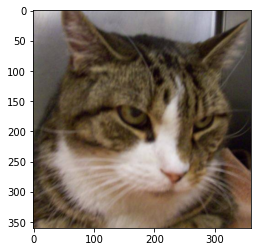

torch.Size([3, 360, 360])


In [255]:
img = dataset_train[randint(0, len(dataset_train))]
imshow(img)
print(img.shape)

In [256]:
if min_size is None or avg_size is None:
  itr = iter(dataloader_train)

  min_width = float('inf')
  min_height = float('inf')

  avg_width = 0
  avg_height = 0

  for i in itr:
    if(i.shape[2] < min_height):
      min_height = i.shape[2]
    if(i.shape[3] < min_width):
      min_width = i.shape[3]
    
    avg_width += i.shape[3]
    avg_height += i.shape[2]

  min_size = (int(min_height), int(min_width))
  avg_size = (int(avg_height/len(itr)), int(avg_width/len(itr)))

print(f"Min size: {min_size}\nAverage size: {avg_size}")

Min size: (33, 42)
Average size: (360, 360)


## Model


### Model definition

In [257]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()                                                              # input image size: 180 x 180
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)   # out image size:  90 x 90
        self.pool = nn.MaxPool2d((2, 2))                                                             # out image size:  45 x 45
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=8, kernel_size=3, stride=2, padding=1)   # out image size:  23 x 23
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1)   # out image size: 45 x 45
        self.upSample = nn.Upsample(scale_factor=2)                                                           # out image size:  90 x 90
        self.conv2 = nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1)  # out image size:  180 x 180
        self.conv3 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1)   # out image size: 360 x 360
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.upSample(x)
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x
    
class ResolutionAutoencoder(nn.Module):
    def __init__(self):
        super(ResolutionAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [258]:
def train(dataloader, model, loss_fn, optimizer, transform=transforms.Resize(input_size)):
    size = len(dataloader.dataset)
    model.train()
    train_loss = []
    for batch, (original_image_batch) in enumerate(dataloader):
        if transform:
          t_image_batch = transform(original_image_batch)

        t_image_batch = t_image_batch.to(device)
        original_image_batch = original_image_batch.to(device)
        # Compute prediction error
        pred = model(t_image_batch)
        loss = loss_fn(pred, original_image_batch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(t_image_batch)
            train_loss.append(loss)
            print(f"train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return (sum(train_loss))/len(train_loss)

In [259]:
def validate(dataloader, model, loss_fn, transform=transforms.Resize(input_size)):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for original_image_batch, _ in dataloader:
            if transform:
              t_image_batch = transform(original_image_batch)
            t_image_batch = t_image_batch.to(device)
            original_image_batch = original_image_batch.to(device)
            pred = model(t_image_batch)
            test_loss += loss_fn(pred, t_image_batch).item()
    test_loss /= num_batches
    
    return test_loss

### Model instance and settings

In [262]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

rae = ResolutionAutoencoder()
rae = rae.to(device)

learning_rate = 1e-3
num_epochs = 1

optimizer = torch.optim.Adam(params=rae.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()

print("Model definition: ")
summary(rae, (3, 180, 180), 1)

Model definition: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 90, 90]           1,568
         MaxPool2d-2            [1, 32, 45, 45]               0
            Conv2d-3             [1, 8, 23, 23]           2,312
           Encoder-4             [1, 8, 23, 23]               0
   ConvTranspose2d-5            [1, 16, 45, 45]           1,168
          Upsample-6            [1, 16, 90, 90]               0
   ConvTranspose2d-7          [1, 32, 180, 180]           8,224
   ConvTranspose2d-8           [1, 3, 360, 360]           1,539
           Decoder-9           [1, 3, 360, 360]               0
Total params: 14,811
Trainable params: 14,811
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.37
Forward/backward pass size (MB): 17.62
Params size (MB): 0.06
Estimated Total Size (MB): 18.04
------------------------

### Train

In [ ]:
val_loss_avg = []
train_loss_avg = []
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(dataloader_train, rae, criterion, optimizer)
    val_loss = validate(dataloader_validation, rae, criterion)
    
    train_loss_avg.append(train_loss)
    val_loss_avg.append(val_loss)
    
    print(f"Train loss: {train_loss:>8f}\nTest Error: {val_loss:>8f} \n")
    
print("Done!")

Epoch 1
-------------------------------
train loss: 0.095500  [    0/20000]
train loss: 0.007316  [ 1000/20000]
train loss: 0.006259  [ 2000/20000]
train loss: 0.005219  [ 3000/20000]
train loss: 0.004370  [ 4000/20000]
train loss: 0.002416  [ 5000/20000]
train loss: 0.002159  [ 6000/20000]
train loss: 0.007612  [ 7000/20000]
train loss: 0.006959  [ 8000/20000]
train loss: 0.002781  [ 9000/20000]


### Learning curve

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(val_loss_avg)
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Evaluate model

In [ ]:
test_loss = validate(dataloader_test, rae, criterion)
print('average reconstruction error: %f' % (test_loss))

## Model Result Visualization